# CoderHouse - Data Engineering

## Entregable N° 2 - Páez Darío

# Importación de módulos

In [1]:
import os
import requests
import pandas as pd
import seaborn as sns
from os import environ as env
import matplotlib.pyplot as plt
import urllib.parse
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, lit, col, avg

# Seaborn theme
sns.set_theme()

In [50]:
# Psycopg
!pip install psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 5.1 MB/s eta 0:00:0000:0100:01


In [51]:
import psycopg2

# Extracción de Datos

## API Datos Argentina

Mediante la API pública del gobierno de Argentina se extrae el **EMAE** (Estimador Mensual de Actividad Económica) para el período Marzo-2013 a Junio-2021, debido a que la llamada a la API solo permite extraer de a **100 registros**.

In [2]:
# Función para formatear la url de conexión con la API
def get_api_call(ids, **kwargs):
    API_BASE_URL = "https://apis.datos.gob.ar/series/api/"
    kwargs["ids"] = ",".join(ids)
    return "{}{}?{}".format(API_BASE_URL, "series", urllib.parse.urlencode(kwargs))

In [3]:
# Formateo de la url de acuerdo a la variable y período deseados
api_call = get_api_call(["143.3_NO_PR_2004_A_21"], start_date="2013-03-01", end_date="2023-06-01")
print(api_call)

https://apis.datos.gob.ar/series/api/series?start_date=2013-03-01&end_date=2023-06-01&ids=143.3_NO_PR_2004_A_21


In [4]:
# Respuesta de la API
result = requests.get(api_call).json()

### A través de pandas se crea una tabla con los resultados obtenidos de la API

In [5]:
df_emae = pd.DataFrame(result['data'], columns=['date', 'EMAE'])

In [6]:
df_emae.head()

,date,EMAE
0,2013-03-01,149.403946
1,2013-04-01,155.941596
2,2013-05-01,167.973479
3,2013-06-01,156.271864
4,2013-07-01,150.731001


In [7]:
# Se incorpora una columna que permita ver la variación respecto a la media
df_emae['variacion'] = df_emae['EMAE'] - df_emae['EMAE'].mean()

In [8]:
df_emae.shape

(100, 3)

In [9]:
df_emae.head()

,date,EMAE,variacion
0,2013-03-01,149.403946,5.043770
1,2013-04-01,155.941596,11.581420
2,2013-05-01,167.973479,23.613304
3,2013-06-01,156.271864,11.911689
4,2013-07-01,150.731001,6.370826


## Canasta básica

A través del explorador de la [API de series de tiempo del Ministerio de Modernización](https://datosgobar.github.io/series-tiempo-ar-explorer/#/series/?ids=444.1_CANASTA_BATAL_0_0_20_94), se obtiene en formato **.csv** los datos de la **canasta básica alimentaria** y **canasta básica total** en pesos de la Ciudad Autónoma de Buenos Aires para el período **Enero-2013/Noviembre-2018** (frecuencia mensual)

In [56]:
df_canasta = pd.read_csv('data/canastas-basicas-ciudad-de-buenos-aires.csv')

In [59]:
# Cambio del nombre de la columna indice_tiempo
df_canasta.rename(columns={'indice_tiempo': 'date'}, inplace=True)

In [60]:
df_canasta.head()

,date,canasta_basica_alimentaria,canasta_basica_total
0,2013-01-01,2634.91,5813.43
1,2013-02-01,2645.91,5852.52
2,2013-03-01,2676.89,5974.26
3,2013-04-01,2702.55,6074.80
4,2013-05-01,2713.25,6150.23


In [61]:
df_canasta.shape

(71, 3)

## Tipo de Cambio 

De la misma manera, se obtiene los datos de tipo de cambio (Dólar-Peso) vendedor del Banco de la Nación Argentina para el período **2014-11-03 a 2022-11-30**. En este caso, la frecuencia de los datos es diaria  

In [62]:
df_cambio = pd.read_csv('data/datos-tipo-cambio-usd-futuro-dolar-frecuencia-diaria.csv')

In [63]:
df_cambio.rename(columns={'indice_tiempo': 'date'}, inplace=True)

In [64]:
df_cambio.head()

,date,tipo_cambio_bna_vendedor,tipo_cambio_a3500,tipo_cambio_mae,volumen_mae,tipo_cambio_implicito_en_adrs,futuro_rofex_usd1m,interes_abierto_1m,futuro_rofex_usd2m,interes_abierto_2m,futuro_rofex_usd3m,interes_abierto_3m,futuro_rofex_usd4m,interes_abierto_4m,futuro_rofex_usd5m,interes_abierto_5m,futuro_rofex_usd6m,interes_abierto_6m
0,2002-03-05,NaN,1.9917,NaN,NaN,2.180124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-03-06,NaN,2.0508,NaN,NaN,2.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-03-07,NaN,2.1375,NaN,NaN,2.343949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-03-08,NaN,2.2033,NaN,NaN,2.227778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2002-03-09,NaN,2.2033,NaN,NaN,2.227778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
df_cambio.shape

(7727, 18)

Vemos que se obtiene una gran cantidad de datos con varios valores nulos y que arranca desde el año 2002. Al analizar los valores nulos se puede ver que la columna de interés (**tipo_cambio_bna_vendedor**) tiene gran cantidad de valores nulos.

In [66]:
df_cambio.isna().sum()

date                                0
tipo_cambio_bna_vendedor         4626
tipo_cambio_a3500                   0
tipo_cambio_mae                  2311
volumen_mae                      4393
tipo_cambio_implicito_en_adrs       2
futuro_rofex_usd1m               2496
interes_abierto_1m               2496
futuro_rofex_usd2m               2496
interes_abierto_2m               2496
futuro_rofex_usd3m               2496
interes_abierto_3m               2496
futuro_rofex_usd4m               2496
interes_abierto_4m               2496
futuro_rofex_usd5m               2496
interes_abierto_5m               2496
futuro_rofex_usd6m               2496
interes_abierto_6m               2496
dtype: int64

In [18]:
#df_cambio2 = df_cambio.copy()

In [19]:
#from datetime import date

In [21]:
#df_cambio2.indice_tiempo = [date.fromisoformat(fecha) for fecha in df_cambio2.indice_tiempo]

In [29]:
#print(df_cambio2.indice_tiempo[0])

2002-03-05


In [67]:
# Filtrado por fecha y se selecciona la columna de interés
df_cambio2 = df_cambio[df_cambio.date > '2014-11-03'][['date', 'tipo_cambio_bna_vendedor']]

In [69]:
df_cambio2.shape

(3100, 2)

In [70]:
# Comprobación de valores nulos
df_cambio2.isna().sum()

date                        0
tipo_cambio_bna_vendedor    0
dtype: int64

In [68]:
df_cambio2.head()

,date,tipo_cambio_bna_vendedor
4627,2014-11-04,8.51
4628,2014-11-05,8.51
4629,2014-11-06,8.51
4630,2014-11-07,8.51
4631,2014-11-08,8.51


# Creación de Tablas en Redshift

## Conexión a través de psycopg

In [52]:
# Connect to Redshift using psycopg2
conn = psycopg2.connect(
    host=env['REDSHIFT_URL'],
    port=env['REDSHIFT_PORT'],
    dbname=env['REDSHIFT_DATABASE'],
    user=env['REDSHIFT_USER'],
    password=env['REDSHIFT_PASSWORD']
)

## Tabla de Actividad Economica

Esta tabla fue creada en el entregable anterior por lo tanto no es necesario volver a crearla

## Tabla de Canasta Básica

In [53]:
cursor = conn.cursor()
cursor.execute(f"""
create table if not exists {env['REDSHIFT_SCHEMA']}.canasta_basica (
    date VARCHAR(10) distkey,
    canasta_basica_alimentaria decimal(6,2),
    canasta_basica_total decimal(6,2)
) sortkey(date);
""")
conn.commit()
cursor.close()
print("Table created!")

Table created!


## Tabla de Tipo de Cambio

In [72]:
cursor = conn.cursor()
cursor.execute(f"""
create table if not exists {env['REDSHIFT_SCHEMA']}.tipo_de_cambio (
    date VARCHAR(10) distkey,
    tipo_cambio_bna_vendedor decimal(3,2)
) sortkey(date);
""")
conn.commit()
cursor.close()
print("Table created!")

Table created!


## Gráfico

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


Text(0.5, 1.0, 'Variación de Estimador Mensual de Actividad Económica')

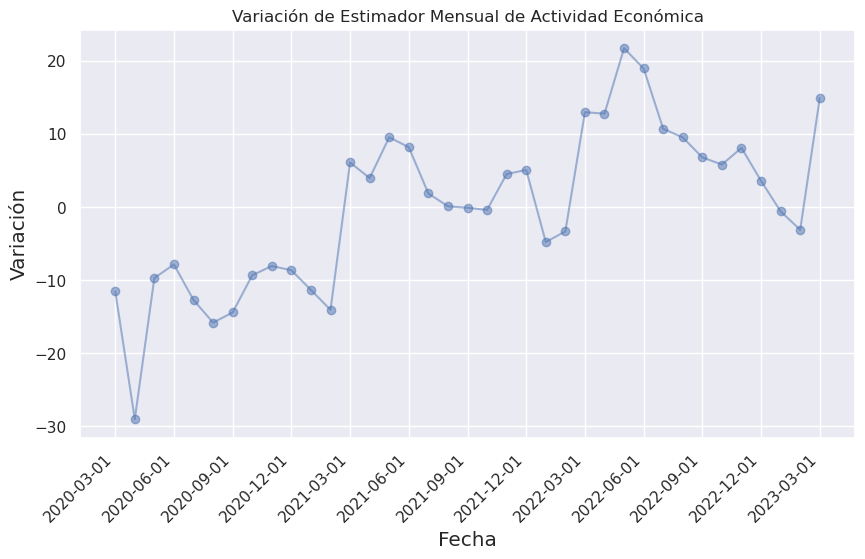

In [30]:
# Gráfico de variación EMAE
fig, ax = plt.subplots(1, figsize=(10, 6))

ax.plot(pd_df.date, 
        pd_df.variacion, 
        marker='o',
        alpha=0.5)

fig.autofmt_xdate(rotation=45)
ax.set_xticks([pd_df['date'][x] for x in range(0, 37, 3)])
ax.set_ylabel('Variación', fontsize='large')
ax.set_xlabel('Fecha', fontsize='large')
plt.title('Variación de Estimador Mensual de Actividad Económica')

Se puede observar el decaímiento notorio de la actividad económica al comienzo de la pandemia en el año 2020. 

## Iniciar Sesión de Spark

In [31]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, lit, col, avg

# Postgres and Redshift JDBCs
driver_path = "/home/coder/working_dir/driver_jdbc/postgresql-42.2.27.jre7.jar"

# Seteo de variables de entorno para que Pyspark cargue los drivers correspondientes
os.environ['PYSPARK_SUBMIT_ARGS'] = f'--driver-class-path {driver_path} --jars {driver_path} pyspark-shell'
os.environ['SPARK_CLASSPATH'] = driver_path

# Create SparkSession 
spark = SparkSession.builder \
        .master("local") \
        .appName("Conexion entre Pyspark y Redshift") \
        .config("spark.jars", driver_path) \
        .config("spark.executor.extraClassPath", driver_path) \
        .getOrCreate()

In [32]:
# Variables de entorno ubicadas en env
env = os.environ

Crear dataframe de Pyspark para guardar los resultados de la consulta a la API

In [33]:
df_to_write = spark.createDataFrame(pd_df, ["date", "EMAE", "variacion"])

In [34]:
df_to_write.printSchema()
df_to_write.show()

root
 |-- date: string (nullable = true)
 |-- EMAE: double (nullable = true)
 |-- variacion: double (nullable = true)

+----------+------------------+--------------------+
|      date|              EMAE|           variacion|
+----------+------------------+--------------------+
|2020-03-01|129.44520369035746| -11.517236880279398|
|2020-04-01|111.93059529183144|  -29.03184527880542|
|2020-05-01|131.24787222442225|  -9.714568346214605|
|2020-06-01|133.09348401362806|  -7.868956557008801|
|2020-07-01|128.24284806343616| -12.719592507200701|
|2020-08-01| 125.1382025859944| -15.824237984642451|
|2020-09-01|126.53017344065384| -14.432267129983018|
|2020-10-01|131.61628833412382|  -9.346152236513035|
|2020-11-01|132.88316888090029|  -8.079271689736572|
|2020-12-01|132.30930118742162|  -8.653139383215233|
|2021-01-01|129.61070151376322|  -11.35173905687364|
|2021-02-01|126.88274749783908| -14.079693072797781|
|2021-03-01|147.05799145471897|   6.095550884082115|
|2021-04-01|144.90968040530902|  

## Crear tabla para insertar datos

## Insertar datos en la tabla

In [38]:
df_to_write.write \
    .format("jdbc") \
    .option("url", f"jdbc:postgresql://{env['REDSHIFT_URL']}:{env['REDSHIFT_PORT']}/{env['REDSHIFT_DATABASE']}") \
    .option("dbtable", f"{env['REDSHIFT_SCHEMA']}.actividad_economica") \
    .option("user", env['REDSHIFT_USER']) \
    .option("password", env['REDSHIFT_PASSWORD']) \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

## Capturas de Redshift en DBeaver

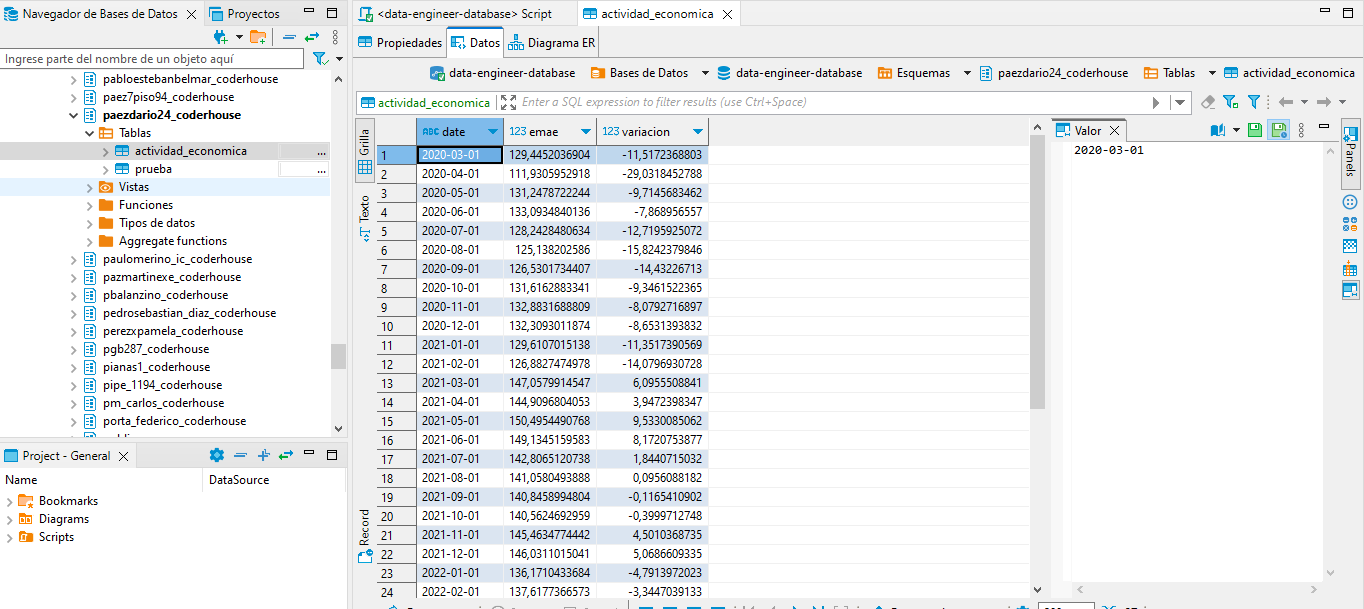